In [21]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import time

In [280]:
# NOTE: THIS CELL TAKES 25 MIN TO RUN (I had to add delays to avoid reaching my API rate limit)
# Preliminary: Fetch relevant blocks
# We wish to construct a time series with a bi-monthly granularity over a 2022-Present. To fetch data at each of these snapshots, we need
# the block ID of an ethereum block at each of these points, to give the global state of our desired liquidity pools at each of these snapshots

# Here, I will fetch block IDs with daily granularity (~1000 data points), and we can later choose which blocks to 
# include in our final time series (dataframe with timestamp -> ethereum block ID).
# Note that we need to use Unix/Epoch time when making our query

# Use Etherscan API. Can cross-check results using Etherscan block/time converter

dates = pd.date_range(start="2022-01-01", end=pd.Timestamp.today(), freq="D")
dates_array = dates.to_numpy() # all dates from 01/01/2022 - 11/29/2025
unix_times = dates.astype(int) // 10**9 # convert to unix time

etherscan_api_key = "H7DU57VXVFGCFWH2Z5B1MV889VR1K7677E"
block_to_date_df = pd.DataFrame(columns=['Datetime', 'Ethereum Block Number'])

for i in range(len(unix_times)):
    timestamp = unix_times[i]
    url = (f"https://api.etherscan.io/v2/api?chainid=1&module=block&action=getblocknobytime&timestamp={timestamp}&closest=before&apikey={etherscan_api_key}")
    response = requests.get(url).json()
    block_number = int(response["result"])
    block_to_date_df.loc[len(block_to_date_df)] = [dates_array[i], block_number]
    time.sleep(1) # Add a one second delay to avoid reaching rate limit for API

block_to_date_df.head(20)

KeyboardInterrupt: 

In [2]:
block_to_date_df.to_csv("datetime_to_eth_block_number.csv")

NameError: name 'block_to_date_df' is not defined

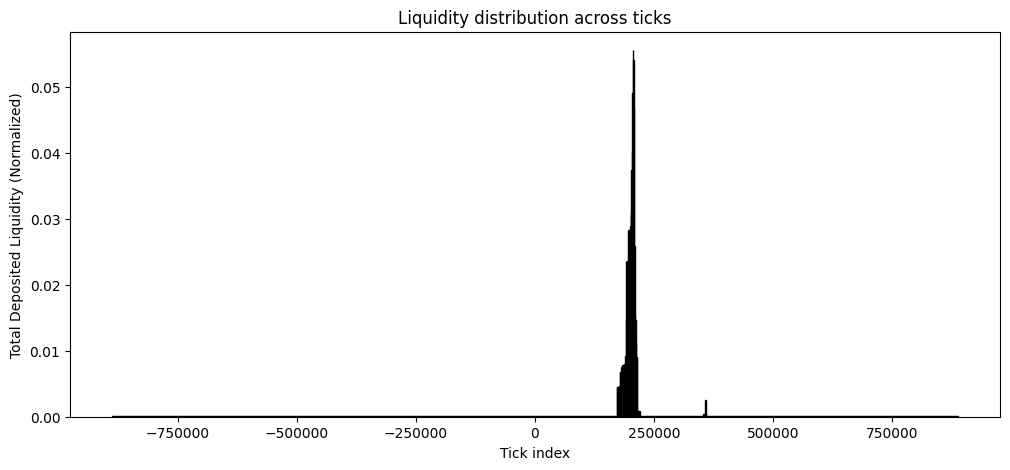

In [19]:
# Liquidity pool 1: ETH/USDC (Example of Workflow)
# i. Get liquidity pool ID using Uniswap API
# We get the address of ETH, USDC using Etherscan.io

# ii. Get a snapshot of current liquidity distribution across ticks (EDA)
# Get all current positions
uniswap_api_key = "2b45e1f034a61c2f41bf4bcd6731335a" # CHANGE THIS
subgraph_id = "5zvR82QoaXYFyDEKLZ9t6v9adgnptxYpKpSbxtgVENFV"
url = f"https://gateway.thegraph.com/api/{uniswap_api_key}/subgraphs/id/{subgraph_id}"

query = """
query GetPositions($poolId: String!, $blockNumber: Int!) {
  positions(
    where: { pool: $poolId, liquidity_gt: 0 }
    first: 1000
    block: { number: $blockNumber }   # <-- block constraint
  ) {
    liquidity
    depositedToken0
    depositedToken1
    withdrawnToken0
    withdrawnToken1
    tickLower {
      tickIdx
    }
    tickUpper {
      tickIdx
    }
  }
}
"""

# CHANGE THESE PARAMETERS TO SPECIFY POOL + BLOCK NUMBER
# FIND BLOCK NUMBER USING DATETIME_TO_ETH_BLOCK_NUMBER DATAFRAME
variables = {"poolId": "0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640".lower(), # CHANGE THIS
            "blockNumber": 15000000   # CHANGE THIS 
            } 

response = requests.post(url, json={"query": query, "variables": variables}, headers={"Content-Type": "application/json"})
data = response.json()

# Convert to dataframe to clean up
positions_df = pd.DataFrame(columns = ['Deposited Token 0', 'Deposited Token 1', 'Total Liquidity Deposited', 'Lower Tick', 'Upper Tick', 'Withdrawn Token 0', 'Withdrawn Token 1'])
for index in range(len(data['data']['positions'])):
    positions_df.loc[len(positions_df)] = [
        data['data']['positions'][index]['depositedToken0'],
        data['data']['positions'][index]['depositedToken1'],
        data['data']['positions'][index]['liquidity'],
        data['data']['positions'][index]['tickLower']['tickIdx'],
        data['data']['positions'][index]['tickUpper']['tickIdx'],
        data['data']['positions'][index]['withdrawnToken0'],
        data['data']['positions'][index]['withdrawnToken1']
    ]
cols_to_convert = [col for col in positions_df.columns]
positions_df[cols_to_convert] = positions_df[cols_to_convert].astype(float)
positions_df.head(60)

# Bin the data
tick_min = np.min(positions_df['Lower Tick'])
tick_max = np.max(positions_df['Upper Tick'])
bin_width = 1000  # change granularity as needed
bins = np.arange(tick_min, tick_max + bin_width, bin_width)
liquidity_per_bin = np.zeros(len(bins) - 1)

for idx, row in positions_df.iterrows():
    # Find bin indices that overlap with this position
    bin_indices = np.where(
        (bins[:-1] < row['Upper Tick']) & (bins[1:] > row['Lower Tick'])
    )[0]
    
    # Add liquidity to these bins
    liquidity_per_bin[bin_indices] += row['Total Liquidity Deposited']

# Normalize Bins (Turn the plot into a density plot)
liquidity_per_bin = liquidity_per_bin / liquidity_per_bin.sum() # We want a time series of this vector (this, at different timestamps)

# x = bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.figure(figsize=(12,5))
plt.bar(bin_centers, liquidity_per_bin, width=bin_width, edgecolor='k')
plt.xlabel("Tick index")
plt.ylabel("Total Deposited Liquidity (Normalized)")
plt.title("Liquidity distribution across ticks")
plt.show()

In [20]:
# Final cleanup:

# Convert ticks to price: this gives the price (amount token0 for one of token1)
positions_df['price_lower_usd_per_eth'] = 1.0001 ** positions_df['Lower Tick']
positions_df['price_upper_usd_per_eth'] = 1.0001**positions_df['Upper Tick']
positions_df['price_lower_eth_per_usd'] = 1 / (1.0001 ** positions_df['Lower Tick'])
positions_df['price_upper_eth_per_usd'] = 1 / (1.0001**positions_df['Upper Tick'])
# If token0 is not USDC, complete this step to get final price in USDC (pegged to USD)
""" 
price = requests.get(
    "https://api.coingecko.com/api/v3/simple/price",
    params={"ids": "ethereum", "vs_currencies": "usd"} # replace ethereum with token0 id
).json()
print(price["ethereum"]["usd"]) # sanity check, replace ethereum with token0 id
token_to_usd = price["ethereum"]["usd"]
positions_df['price_lower_usd'] = positions_df['price_lower_usd_per_eth'].apply(lambda x: x * token_to_usd)
positions_df['price_upper_usd'] = positions_df['price_lower_usd_per_eth'].apply(lambda x: x * token_to_usd)
positions_df['price_lower_usd'] = positions_df['price_lower_eth_per_usd'].apply(lambda x: x * token_to_usd)
positions_df['price_upper_usd'] = positions_df['price_lower_eth_per_usd'].apply(lambda x: x * token_to_usd)

"""
# Normalize Liquidity
positions_df['Normalized Liquidity'] = positions_df['Total Liquidity Deposited'].apply(lambda x: x / sum(positions_df['Total Liquidity Deposited']))
cleaned_positions_df = positions_df[['Normalized Liquidity', 'price_lower_usd_per_eth', 'price_upper_usd_per_eth',
                                    'price_lower_eth_per_usd', 'price_upper_eth_per_usd']]
# Bin the data
tick_min = -887272
tick_max = 887272
bin_width = 600  # change granularity as needed
bins = np.arange(tick_min, tick_max + bin_width, bin_width)
liquidity_per_bin = np.zeros(len(bins) - 1)

for idx, row in positions_df.iterrows():
    # Find bin indices that overlap with this position
    bin_indices = np.where(
        (bins[:-1] < row['Lower Tick']) & (bins[1:] > row['Upper Tick'])
    )[0]
    
    # Add liquidity to these bins
    liquidity_per_bin[bin_indices] += row['Normalized Liquidity']
    
print(liquidity_per_bin)
positions_df.head(20)

[0. 0. 0. ... 0. 0. 0.]
95486.26000000001


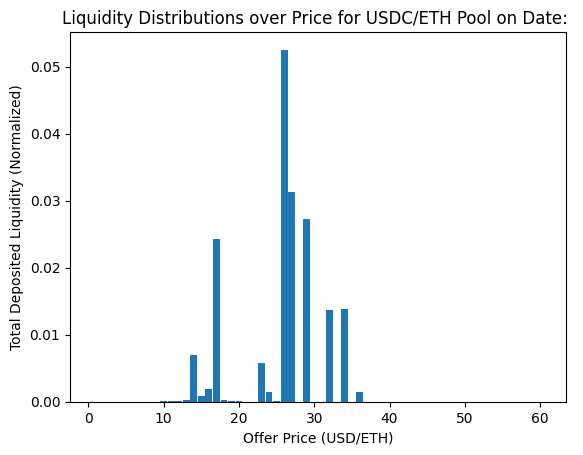

In [275]:
# Create histogram (Prettier Version)
# Bin indices (1-based)
bins = np.arange(1, len(liquidity_per_bin[1790:1850]) + 1)
plt.bar(bins, liquidity_per_bin[1790:1850], width=0.9)
plt.xlabel("Offer Price (USD/ETH)")
plt.ylabel("Total Deposited Liquidity (Normalized)")
plt.title("Liquidity Distributions over Price for USDC/ETH Pool on Date: ") # CHANGE DATE
plt.show()

In [262]:
# Metadata
# Get all current positions
uniswap_api_key = "2b45e1f034a61c2f41bf4bcd6731335a" # CHANGE THIS
subgraph_id = "5zvR82QoaXYFyDEKLZ9t6v9adgnptxYpKpSbxtgVENFV"
url = f"https://gateway.thegraph.com/api/{uniswap_api_key}/subgraphs/id/{subgraph_id}"

query = """
query PoolAtBlock($poolId: String!, $blockNumber: Int!) {
  pool(id: $poolId, block: { number: $blockNumber }) {
    tick
    token0Price
    token1Price
    liquidity
    totalValueLockedUSD
    volumeUSD
  }
}
"""


# CHANGE THESE PARAMETERS TO SPECIFY POOL + BLOCK NUMBER
# FIND BLOCK NUMBER USING DATETIME_TO_ETH_BLOCK_NUMBER DATAFRAME
variables = {"poolId": "0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640".lower(), # CHANGE THIS
            "blockNumber": 15259746   # CHANGE THIS 
            } 

response = requests.post(url, json={"query": query, "variables": variables}, headers={"Content-Type": "application/json"})
data = response.json()
print(data)

{'data': {'pool': {'liquidity': '13580841122811141262', 'tick': '202347', 'token0Price': '1631.494804402202442406512197262385', 'token1Price': '0.0006129348357725300558274128393480731', 'totalValueLockedUSD': '289949670.2016527224218632384439', 'volumeUSD': '251828065691.6778694010215751870427'}}}
